# Zillow 2017

## Table of Contents

* [Package Imports](#packages_import)
* [Acquire](#data_import)
* [Prepare](#prepare)
* [Explore Process](#explore1)
    * [Question 1](#q_1)
        * [Q1 Visualization](#q_1_viz)
        * [Q1 Statistical Test](#q_1_stats)
        * [Q1 Answer](#q_1_ans)
    * [Question 2](#q_2)
        * [Q2 Visualization](#q_2_viz)
        * [Q2 Statistical Test](#q_2_stats)
        * [Q2 Answer](#q_2_ans)    
    * [Question 3](#q_3)
        * [Q3 Visualization](#q_3_viz)
        * [Q3 Statistical Test](#q_3_stats)
        * [Q3 Answer](#q_3_ans)    
    * [Question 4](#q_4)
        * [Q4 Visualization](#q_4_viz)
        * [Q4 Statistical Test](#q_4_stats)
        * [Q4 Answer](#q_4_ans)
* [Explore Summary](#explore2)
* [Modeling](#modeling)
    * [Introduction](#m_intro)
    * [Baseline](#baseline)
    * [Model 1](#mod_1)
    * [Model 2](#mod_2)
    * [Model 3](#mod_3)
    * [Model 4](#mod_4)
* [Conclusion](#conclusion)
    * [Summery](#c_summery)
    * [Recommendations](#c_recs)
    * [Next Steps](#c_steps)
* [ReadMe](#readme)

## Package Imports <a class="anchor" id="packages_import"></a>


In [1]:
#Import the varius packages
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import normaltest, kstest, norm
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

#Sklearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error

from acquire import wrangle_zillow, train_validate, check_p_val, scale_zillow, find_baseline, train_val_test

In [2]:
#Sets options to show more information
pd.options.display.max_columns = None
pd.options.display.width = 100
pd.options.display.max_colwidth = None
pd.options.display.max_rows = 200

## Concerns

- Issues with the data

## Acquire<a class="anchor" id="data_import"></a>

* Data came from Codeup SQL server who acquired it from a Kaggle challenge.
* Started with 52441 observations and 4 features.
* Acquired on 1/19/2023
* What is the size of your data? (columns and rows)
* What does each observation represent?
* What does each column represent?

dropping blank values shifted the target mean by -1662 (small amount)

In [3]:
#Get the data from the SQL server and do a bit of cleaning
df = wrangle_zillow()

In [4]:
len(df)

50696

In [5]:
ml_df = df

In [6]:
ml_df = df.drop(columns='transactiondate')

In [7]:
df['transactiondate'] = pd.to_datetime(df['transactiondate'])

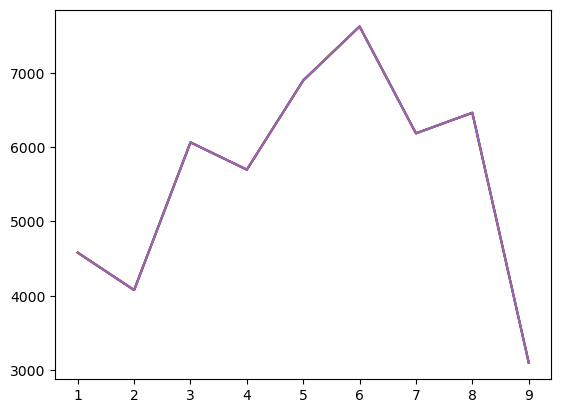

In [8]:
plt.plot(df.groupby(df.transactiondate.dt.month).count())

In [9]:
len(df.transactiondate.value_counts())

255

## Prepare <a class="anchor" id="prepare"></a>

* Dropping the 83 observations with NA values shifted the tax_value mean by -1662 and left 52358 observations to explore.
* After initial exploration, 1,662 outliers beyond the .99 quantile were dropped, resulting in 50696 observations.

## Explore process <a class="anchor" id="explore1"></a>

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influenced your analysis
* Remember to split your data before exploring how different variables relate to one another
* Each question should be stated directly 
* Each question should be supported by a visualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two
* See the following example, and read the comments in the next cell

## Observations in Train DataFrame
- 41 where bedrooms = 0. Code: `train[train.bedrooms == 0].describe().T`
- 33 where bathrooms = 0. Code: `train[train.bathrooms == 0].describe().T`
- Bedrooms: min = 0, max = 10
- Bathrooms: min = 0, max = 10

In [10]:
#Creates a list for iteration
train_cols = ['tax_value','bedrooms','bathrooms','sqft']

In [11]:
#Sets variables to automatically pass into functions
random_seed = 1969
alpha = 0.05
target_col = 'tax_value'

In [12]:
#Splits data
train, val, test = train_validate(df)

In [13]:
#Looks at data types
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28389 entries, 44846 to 46846
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tax_value        28389 non-null  float64       
 1   bedrooms         28389 non-null  float64       
 2   bathrooms        28389 non-null  float64       
 3   sqft             28389 non-null  float64       
 4   transactiondate  28389 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.3 MB


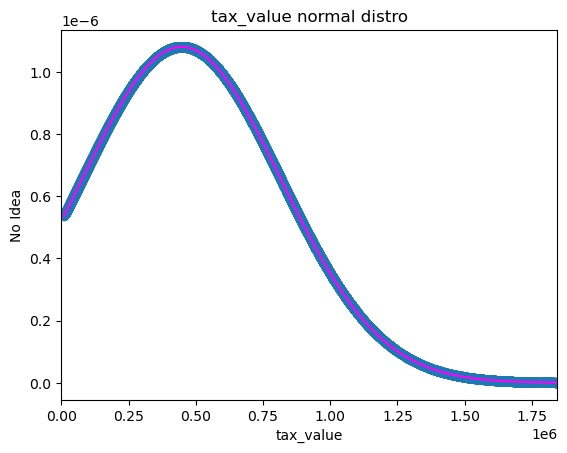

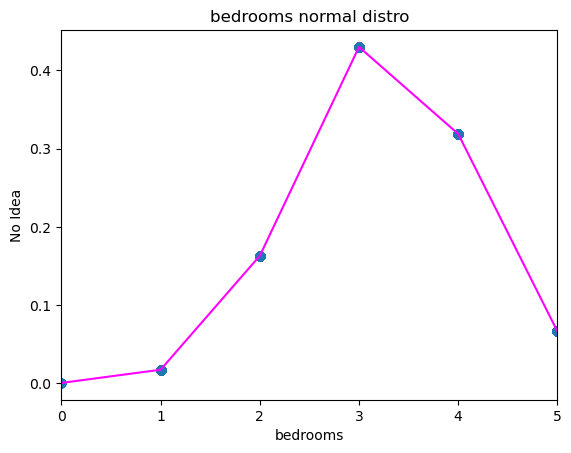

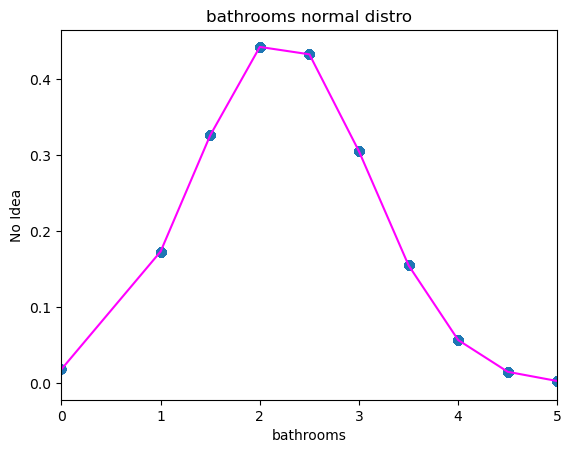

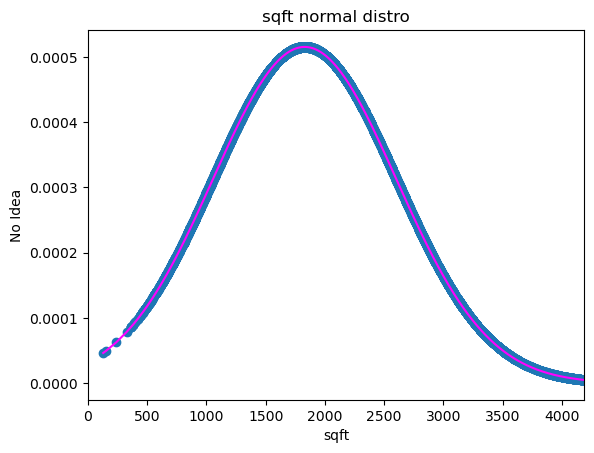

In [14]:
for col in train_cols:

    # Set variables
    x_axis = train[col].sort_values()
    xmax = train[col].quantile(q=0.99)


    # Calculating mean and standard deviation
    mean = statistics.mean(x_axis)
    sd = statistics.stdev(x_axis)
    
    #Build a graph
    plt.scatter(x_axis, norm.pdf(x_axis, mean, sd))
    plt.plot(x_axis, norm.pdf(x_axis, mean, sd), c='magenta')
    plt.xlabel(col)
    plt.ylabel('No Idea')
    plt.title(f'{col} normal distro')
    plt.xlim(left = 0,right = xmax)

    plt.show()

Stats tests: https://datascienceinpractice.github.io/tutorials/11-TestingDistributions.html

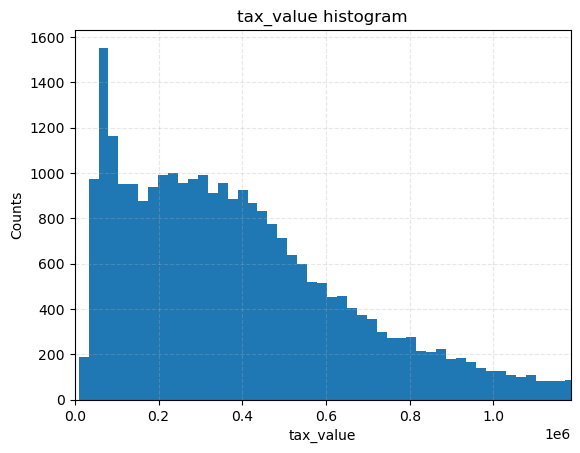

Normaltest p-value is: 0.00 

Statistic: 	1.00 
P-Value: 	0.00e+00

We have evidence to reject the null hypothesis. tax_value does not have a normal distribution

*************************************


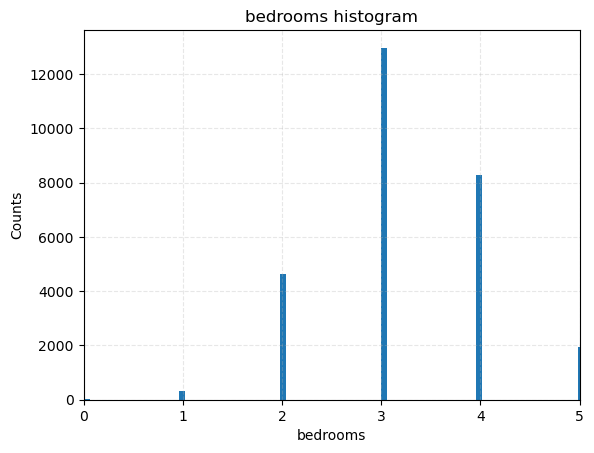

Normaltest p-value is: 0.00 

Statistic: 	0.96 
P-Value: 	0.00e+00

We have evidence to reject the null hypothesis. bedrooms does not have a normal distribution

*************************************


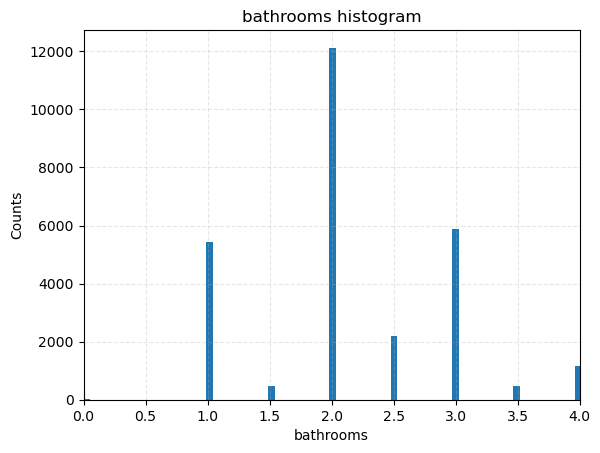

Normaltest p-value is: 0.00 

Statistic: 	0.84 
P-Value: 	0.00e+00

We have evidence to reject the null hypothesis. bathrooms does not have a normal distribution

*************************************


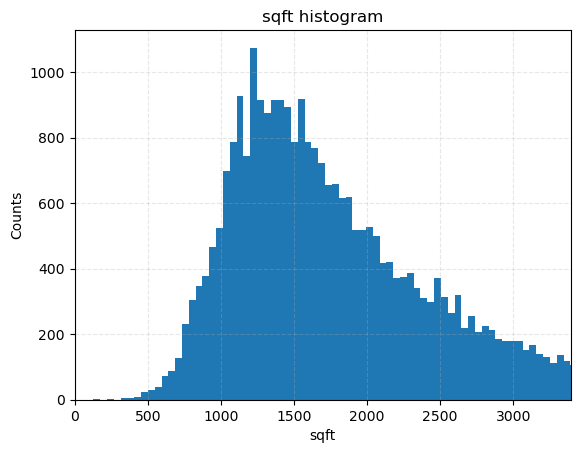

Normaltest p-value is: 0.00 

Statistic: 	1.00 
P-Value: 	0.00e+00

We have evidence to reject the null hypothesis. sqft does not have a normal distribution

*************************************


In [15]:
#Visualization for the distribution of each column
for col in train_cols:
    

    # Drawing a graph
    plt.grid(True, alpha=0.3, linestyle="--")

    xmax=train[col].quantile(q=0.95)
    plt.hist(x=train[col], bins=100) 

    plt.xlabel(col)
    plt.xlim(left=0,right=xmax)
    plt.ylabel('Counts')
    plt.title(f'{col} histogram')
    plt.show()
    
    
    # Run normal test on the data
    stat, p_val = kstest(train[col], 'norm', alternative='less')
    h0 = f'{col} has a normal distribution'
    ha = f'{col} does not have a normal distribution'
    
    # Check the p-value of the normaltest
    print(f'Normaltest p-value is: {p_val:1.2f} \n')
    print(f'Statistic: \t{stat:1.2f} \nP-Value: \t{p_val:1.2e}\n')

    # With alpha value of 0.05, how should we proceed
    check_p_val(p_val, h0, ha, alpha=0.05)
    print("")
    print("*************************************")

### Question 1 <a class="anchor" id="q_1"></a>

- H0: Square feet and tax value are independent variables.
- HA: Square feet and tax value have a relationship.

#### Q1 Visualization <a class="anchor" id="q_1_viz"></a>

<AxesSubplot:title={'center':'Tax value versus Square feet'}, xlabel='sqft', ylabel='tax_value'>

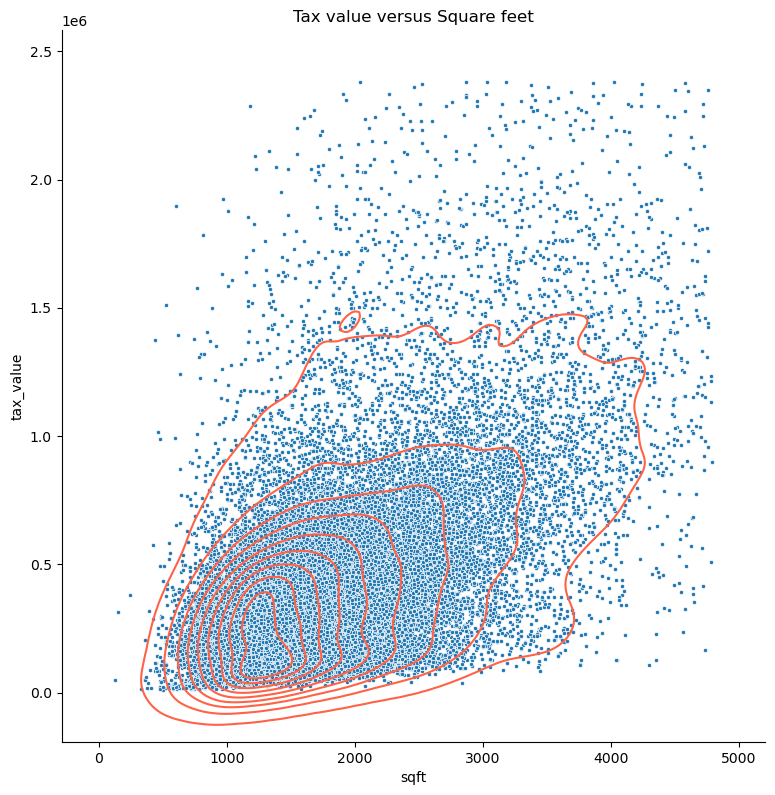

In [16]:
sns.relplot(data=train, x='sqft', y='tax_value', marker=".", height=8, aspect=1).set(title=f'Tax value versus Square feet')
sns.kdeplot(data=train, x='sqft', y='tax_value', c='tomato')

#### Q1 Statistical Test <a class="anchor" id="q_1_stats"></a>

In [17]:
h0 = "Square feet and tax value are independent."
ha = "Square feet and tax value have a relationship."

In [18]:
s, p_val = stats.spearmanr(train['sqft'], train['tax_value'])

#### Q1 Answer <a class="anchor" id="q_1_ans"></a>

In [19]:
check_p_val(p_val, h0, ha, alpha=0.05)

We have evidence to reject the null hypothesis. Square feet and tax value have a relationship.


### Question 2 <a class="anchor" id="q_2"></a>

- H0: Bedroom count and tax value are independent variables.
- HA: Bedroom count and tax value have a relationship.

#### Q2 Visualization <a class="anchor" id="q_2_viz"></a>

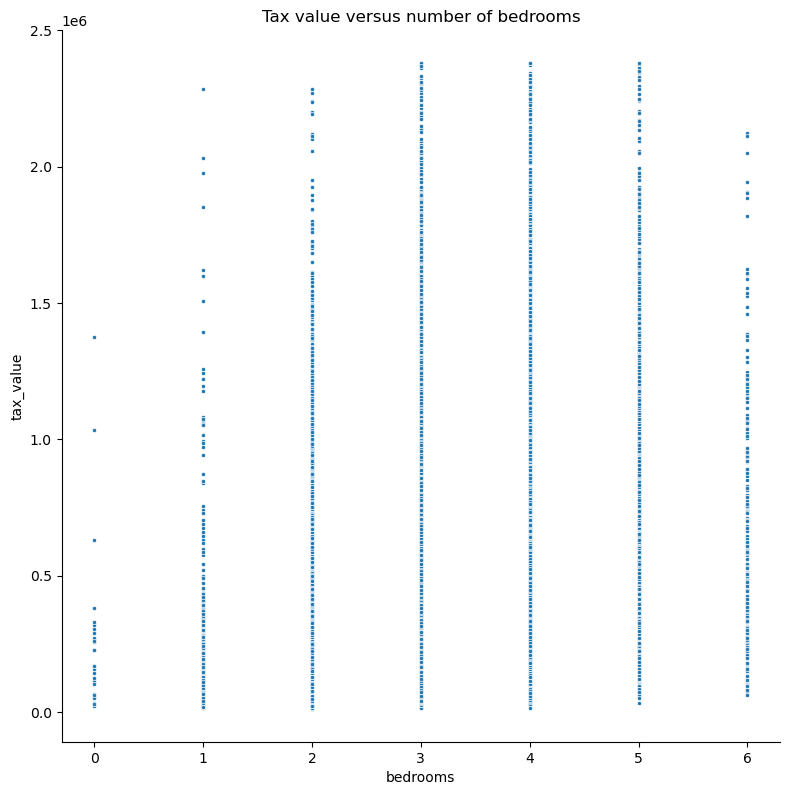

In [20]:
sns.relplot(data=train, x='bedrooms', y='tax_value', marker=".", height=8, aspect=1).set(title=f'Tax value versus number of bedrooms')

#### Q2 Statistical Test <a class="anchor" id="q_2_stats"></a>

In [21]:
h0 = "Number of bedrooms and tax value are independent."
ha = "Number of bedrooms and tax value have a relationship."

In [22]:
s, p_val = stats.spearmanr(train['bedrooms'], train['tax_value'])

#### Q2 Answer <a class="anchor" id="q_2_ans"></a>

In [23]:
check_p_val(p_val, h0, ha, alpha=0.05)

We have evidence to reject the null hypothesis. Number of bedrooms and tax value have a relationship.


### Question 3 <a class="anchor" id="q_3"></a>

- H0: Bathroom count and tax value are independent variables.
- HA: Bathroom count and tax value have a relationship.

#### Q3 Visualization <a class="anchor" id="q_3_viz"></a>

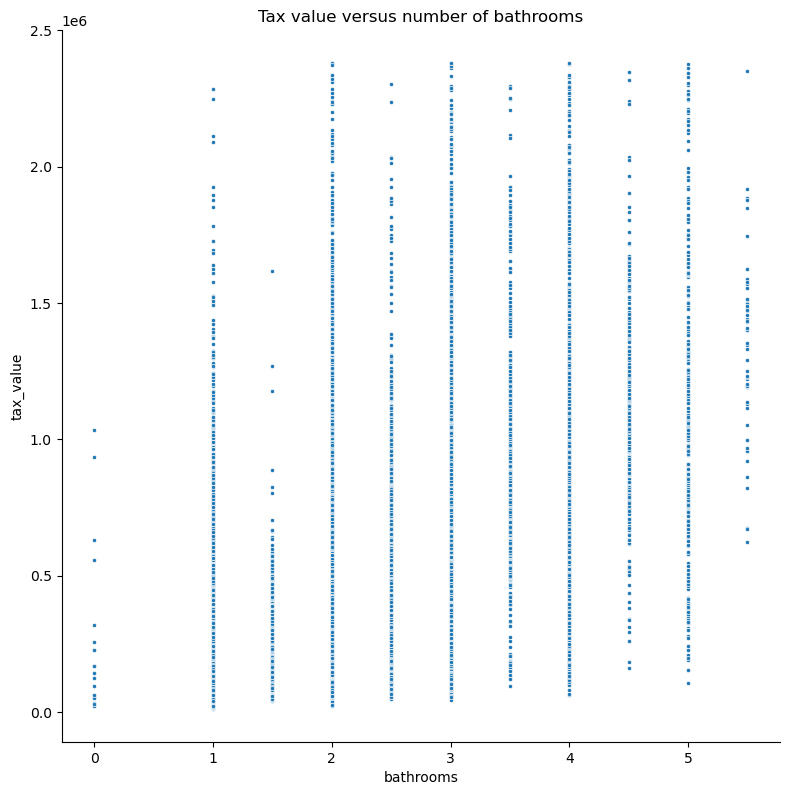

In [24]:
sns.relplot(data=train, x='bathrooms', y='tax_value', marker='.', height=8, aspect=1).set(title=f'Tax value versus number of bathrooms')

#### Q3 Statistical Test <a class="anchor" id="q_3_stats"></a>

In [25]:
h0 = "Number of bathrooms and tax value are independent."
ha = "Number of bathrooms and tax value have a relationship."

In [26]:
s, p_val = stats.spearmanr(train['bathrooms'], train['tax_value'])

#### Q3 Answer <a class="anchor" id="q_3_ans"></a>

In [27]:
check_p_val(p_val, h0, ha, alpha=0.05)

We have evidence to reject the null hypothesis. Number of bathrooms and tax value have a relationship.


### Question 4 <a class="anchor" id="q_4"></a>

Ask something about the bedroom pyramid

#### Q4 Visualization <a class="anchor" id="q_4_viz"></a>

#### Q4 Statistical Test <a class="anchor" id="q_4_stats"></a>

#### Q4 Answer <a class="anchor" id="q_4_ans"></a>

## Explore summary <a class="anchor" id="explore2"></a>

## Modeling <a class="anchor" id="modeling"></a>

### Preparing the data for modeling

#### Creating dummy columns for catagorical data

In [28]:
ml_df = pd.get_dummies(columns=['bedrooms', 'bathrooms'], data=ml_df)

In [29]:
train, val, test = train_validate(ml_df)

#### Scaling the columns with continuous data

In [30]:
#Scaling the data
train, val, test = scale_zillow(train, val, test, scaler_model = 3, cont_columns = ['sqft'])

In [31]:
#Ensuring transoform happened correctly
train.head()

,tax_value,sqft,bedrooms_0.0,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bathrooms_0.0,bathrooms_1.0,bathrooms_1.5,bathrooms_2.0,bathrooms_2.5,bathrooms_3.0,bathrooms_3.5,bathrooms_4.0,bathrooms_4.5,bathrooms_5.0,bathrooms_5.5
44846,551000.0,0.145621,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
33265,418172.0,-0.035642,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
13265,287801.0,-0.292261,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5521,157978.0,0.709776,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
50300,571613.0,-0.065173,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### Seperating the target data from the features

In [32]:
#Splits out target feature for machine learning models
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test(train, val, test, target_col)

#### Feature Selection

In [33]:
# Future development

### Introduction <a class="anchor" id="m_intro"></a>

### Baseline <a class="anchor" id="baseline"></a>

In [34]:
#Eastablishes the standard to beat
baseline = find_baseline(y_train)

RMSE Mean training baseline: 369,346
*****************************************
RMSE Median training baseline: 379,222


In [35]:
#metrics
rmse_scores = []

### Model 1 <a class="anchor" id="mod_1"></a>

#### LinearRegression(OLS)

In [36]:
lm = LinearRegression(normalize=True)

In [37]:
lm.fit(X_train, y_train)

LinearRegression(normalize=True)

In [38]:
#Train
lm_preds = pd.DataFrame({'actual':y_train})

In [39]:
#Train
lm_preds['pred_lm'] = lm.predict(X_train)

In [40]:
lm_val_preds = pd.DataFrame({'actual':y_val})

In [41]:
len(lm_val_preds)

7098

In [42]:
#Validate
lm_val_preds['lm_val_preds'] = lm.predict(X_val)

In [43]:
#Validate
lm_val_preds.head()

,actual,lm_val_preds
32923,89544.0,285696.0
8931,525000.0,766976.0
44110,980125.0,596992.0
33210,581186.0,400384.0
2026,573616.0,352256.0


In [44]:
#Train
rmse_train = mean_squared_error(lm_preds['actual'], lm_preds['pred_lm'], squared=False) 

In [45]:
#Validate
rmse_val = mean_squared_error(lm_val_preds['actual'], lm_val_preds['lm_val_preds'], squared=False) 

In [46]:
rmse_scores.append({'Model':'OLS Linear',
                    'RMSE on Train': rmse_train,
                    'RMSE on Validate': rmse_val})

In [47]:
rmse_scores

[{'Model': 'OLS Linear',
  'RMSE on Train': 300477.14553201705,
  'RMSE on Validate': 299672.62335289415}]

### Model 2 <a class="anchor" id="mod_2"></a>

#### LassoLars

In [48]:
lars = LassoLars(alpha=.25)

In [49]:
lars.fit(X_train, y_train)

LassoLars(alpha=0.25)

In [50]:
#Train
ll_preds = pd.DataFrame({'actual':y_train})

In [51]:
#Train
ll_preds['pred_ll'] = lars.predict(X_train)

In [52]:
#Validate
ll_val_preds = pd.DataFrame({'actual':y_val})

In [53]:
#Validate
ll_val_preds['ll_val_preds'] = lars.predict(X_val)

In [54]:
#Train
rmse_train = mean_squared_error(ll_preds['actual'], ll_preds['pred_ll'], squared=False) 

In [55]:
#Validate
rmse_val = mean_squared_error(ll_val_preds['actual'], ll_val_preds['ll_val_preds'], squared=False) 

In [56]:
rmse_scores.append({'Model':'Lasso Lars',
                    'RMSE on Train': rmse_train,
                    'RMSE on Validate': rmse_val})

In [57]:
rmse_scores

[{'Model': 'OLS Linear',
  'RMSE on Train': 300477.14553201705,
  'RMSE on Validate': 299672.62335289415},
 {'Model': 'Lasso Lars',
  'RMSE on Train': 300469.6809351964,
  'RMSE on Validate': 299636.5862558782}]

### Model 3 <a class="anchor" id="mod_3"></a>

#### TweedieRegressor (GLM)

In [58]:
glm = TweedieRegressor(power=1, alpha=1)

In [59]:
glm.fit(X_train, y_train)

TweedieRegressor(alpha=1, power=1)

In [60]:
#Train
glm_preds = pd.DataFrame({'actual':y_train})

In [61]:
#Train
glm_preds['pred_glm'] = glm.predict(X_train)

In [62]:
#Validate
glm_val_preds = pd.DataFrame({'actual':y_val})

In [63]:
#Validate
glm_val_preds['glm_val_preds'] = glm.predict(X_val)

In [64]:
#Train
rmse_train = mean_squared_error(glm_preds['actual'], glm_preds['pred_glm'], squared=False) 

In [65]:
#Validate
rmse_val = mean_squared_error(glm_val_preds['actual'], glm_val_preds['glm_val_preds'], squared=False) 

In [66]:
rmse_scores.append({'Model':'Tweedie',
                    'RMSE on Train': rmse_train,
                    'RMSE on Validate': rmse_val})

In [67]:
rmse_scores

[{'Model': 'OLS Linear',
  'RMSE on Train': 300477.14553201705,
  'RMSE on Validate': 299672.62335289415},
 {'Model': 'Lasso Lars',
  'RMSE on Train': 300469.6809351964,
  'RMSE on Validate': 299636.5862558782},
 {'Model': 'Tweedie',
  'RMSE on Train': 302025.4641130784,
  'RMSE on Validate': 301788.6397288318}]

### Model 4 <a class="anchor" id="mod_4"></a>

#### Polynomial Regression

In [68]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=1)

In [69]:
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

In [70]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_val)
X_test_degree2 = pf.transform(X_test)

#### Linear Regression

In [71]:
lm2 = LinearRegression(normalize=True)

In [72]:
lm2.fit(X_train_degree2, y_train)

LinearRegression(normalize=True)

In [73]:
#Train
lm2_preds = pd.DataFrame({'actual':y_train})

In [74]:
#Train
lm2_preds['pred_lm2'] = lm2.predict(X_train_degree2)

In [75]:
#Validate
lm2_val_preds = pd.DataFrame({'actual':y_val})

In [76]:
#Validate
lm2_val_preds['lm2_val_preds'] = lm2.predict(X_validate_degree2)

In [77]:
#Train
rmse_train = mean_squared_error(lm2_preds['actual'], lm2_preds['pred_lm2'], squared=False) 

In [78]:
#Validate
rmse_val = mean_squared_error(lm2_val_preds['actual'], lm2_val_preds['lm2_val_preds'], squared=False) 

In [79]:
rmse_scores.append({'Model':'Polynomial',
                    'RMSE on Train': rmse_train,
                    'RMSE on Validate': rmse_val})

In [80]:
rmse_scores

[{'Model': 'OLS Linear',
  'RMSE on Train': 300477.14553201705,
  'RMSE on Validate': 299672.62335289415},
 {'Model': 'Lasso Lars',
  'RMSE on Train': 300469.6809351964,
  'RMSE on Validate': 299636.5862558782},
 {'Model': 'Tweedie',
  'RMSE on Train': 302025.4641130784,
  'RMSE on Validate': 301788.6397288318},
 {'Model': 'Polynomial',
  'RMSE on Train': 300479.62917014066,
  'RMSE on Validate': 299697.11265816644}]

In [81]:
rmse_scores = pd.DataFrame(rmse_scores)

#### Plotting the results

In [82]:
rmse_min = min([rmse_scores['RMSE on Train'].min(), rmse_scores['RMSE on Validate'].min(), baseline])
rmse_max = max([rmse_scores['RMSE on Train'].max(), rmse_scores['RMSE on Validate'].max(), baseline])
rmse_range = rmse_max - rmse_min

In [83]:
lower_limit = rmse_min * 0.8
upper_limit = rmse_max * 1.05

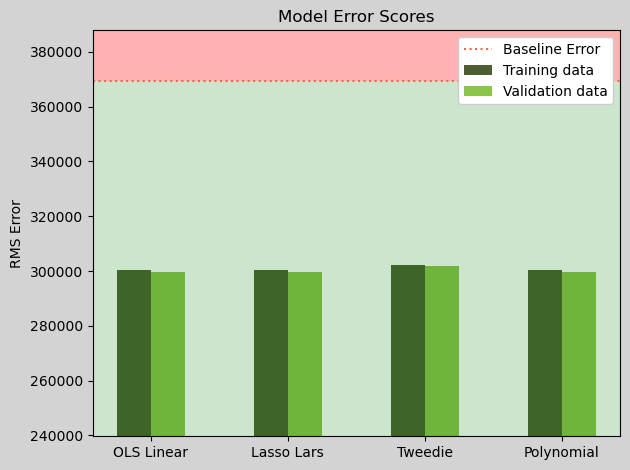

In [84]:
x = np.arange(len(rmse_scores))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(facecolor="lightgray")
rects1 = ax.bar(x - width/2, rmse_scores['RMSE on Train'], width, label='Training data', color='#4e5e33') #Codeup dark green
rects2 = ax.bar(x + width/2, rmse_scores['RMSE on Validate'], width, label='Validation data', color='#8bc34b') #Codeup light green

# Need to have baseline input:
plt.axhline(baseline, label="Baseline Error", c='tomato', linestyle=':')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.axhspan(0, baseline, facecolor='green', alpha=0.2)
ax.axhspan(baseline, upper_limit, facecolor='red', alpha=0.3)
ax.set_ylabel('RMS Error')
ax.set_title('Model Error Scores')
ax.set_xticks(x, rmse_scores['Model'])

plt.ylim(bottom=lower_limit, top = upper_limit)

ax.legend(loc='upper right', framealpha=1)

#ax.bar_label(rects1, padding=4)
#ax.bar_label(rects2, padding=4)
fig.tight_layout()

plt.show()

## Conclusion <a class="anchor" id="conclusion"></a>

### Summery <a class="anchor" id="c_summery"></a>

### Recommendations <a class="anchor" id="c_recs"></a>

### Next Steps <a class="anchor" id="c_steps"></a>

## ReadMe <a class="anchor" id="readme"></a>

Your README should contain all of the following elements:

* **Title** Gives the name of your project
* **Project Description** Describes what your project is and why it is important 
* **Project Goal** Clearly states what your project sets out to do and how the information gained can be applied to the real world
* **Initial Hypotheses** Initial questions used to focus your project 
* **Project Plan** Guides the reader through the different stages of the pipeline as they relate to your project
* **Data Dictionary** Gives a definition for each of the features used in your report and the units they are measured in, if applicable
* **Steps to Reproduce** Gives instructions for reproducing your work. i.e. Running your notebook on someone else's computer.

# Review previous feedback